# MNIST with SciKit-Learn and skorch

This notebooks shows how to define and train a simple Neural-Network with PyTorch and use it via skorch with SciKit-Learn.

<table align="left"><td>
<a target="_blank" href="https://colab.research.google.com/github/skorch-dev/skorch/blob/master/notebooks/MNIST.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>  
</td><td>
<a target="_blank" href="https://github.com/skorch-dev/skorch/blob/master/notebooks/MNIST.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td></table>

In [1]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

## Loading Data
Using SciKit-Learns ```fetch_openml``` to load MNIST data.

In [2]:
mnist = fetch_openml('mnist_784')

In [3]:
mnist.data.shape

(70000, 784)

## Preprocessing Data

Each image of the MNIST dataset is encoded in a 784 dimensional vector, representing a 28 x 28 pixel image. Each pixel has a value between 0 and 255, corresponding to the grey-value of a pixel.<br />
The above ```featch_mldata``` method to load MNIST returns ```data``` and ```target``` as ```uint8``` which we convert to ```float32``` and ```int64``` respectively.

In [4]:
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')

In [5]:
X.min(), X.max()

(0.0, 255.0)

> Note: data is not normalized. We will use the sklearn standard scaler to do this in a pipeline

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

In [7]:
assert(X_train.shape[0] + X_test.shape[0] == mnist.data.shape[0])

In [8]:
X_train.shape, y_train.shape

((52500, 784), (52500,))

### Print a selection of training images and their labels

In [9]:
def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

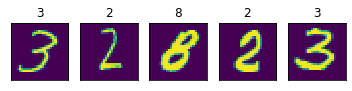

In [10]:
plot_example(X_train, y_train)

## Build Neural Network with PyTorch
Simple, fully connected neural network with one hidden layer. Input layer has 784 dimensions (28x28), hidden layer has 98 (= 784 / 8) and output layer 10 neurons, representing digits 0 - 9.

In [11]:
import torch
from torch import nn
import torch.nn.functional as F
from skorch import NeuralNetClassifier

C:\Users\jamesl\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [13]:
mnist_dim = X.shape[1]
hidden_dim = int(mnist_dim/8)
output_dim = len(np.unique(mnist.target))

In [14]:
mnist_dim, hidden_dim, output_dim

(784, 98, 10)

A Neural network in PyTorch's framework.

In [15]:
class ClassifierModule(nn.Module):
    def __init__(self, num_hidden=100, dropout=.5, nonlin=F.relu):
        super(ClassifierModule, self).__init__()
        
        self.hidden = nn.Linear(784, num_hidden)
        self.nonlin = nonlin
        self.dropout = nn.Dropout(dropout)
        self.output = nn.Linear(num_hidden, 10)

    def forward(self, X, **kwargs):
        X = self.nonlin(self.hidden(X))
        X = self.dropout(X)
        X = F.softmax(self.output(X), dim=-1)
        return X

skorch allows to use PyTorch's networks in the SciKit-Learn setting:

In [16]:
torch.manual_seed(0)

net = NeuralNetClassifier(
    ClassifierModule,
    max_epochs=20,
    lr=.1,
    device=device,
)

### Combine network with standard scaler in pipeline
To avoid big weights that deal with the pixel values from between [0, 255], we scale `X` down. A commonly used range is [0, 1].

In [17]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

In [18]:
# add a standard scaler step before
pipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('net', net),
])

In [19]:
pipe.fit(X_train, y_train)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8389       0.8868        0.4033  1.6604
      2        0.4273       0.9088        0.3095  1.9302
      3        0.3575       0.9232        0.2617  1.9237
      4        0.3182       0.9296        0.2399  1.9467
      5        0.2908       0.9361        0.2159  1.9336
      6        0.2720       0.9411        0.1976  1.9015
      7        0.2552       0.9459        0.1857  1.9372
      8        0.2429       0.9485        0.1748  1.9228
      9        0.2294       0.9514        0.1651  1.9010
     10        0.2195       0.9532        0.1614  1.9091
     11        0.2146       0.9550        0.1530  1.9010
     12        0.2059       0.9561        0.1469  1.9163
     13        0.2002       0.9579        0.1414  1.9218
     14        0.1940       0.9583        0.1385  1.9823
     15        0.1901       0.9592        0.1333  1.9040
     16        0.1834       0.9

Pipeline(memory=None,
         steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('net',
                 <class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ClassifierModule(
    (hidden): Linear(in_features=784, out_features=100, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (output): Linear(in_features=100, out_features=10, bias=True)
  ),
))],
         verbose=False)

## Prediction

In [20]:
y_pred = pipe.predict(X_test)

In [21]:
accuracy_score(y_test, y_pred)

0.9629714285714286

An accuracy of about 96% for a network with only one hidden layer is not too bad.

Let's take a look at some predictions that went wrong:

In [22]:
error_mask = y_pred != y_test

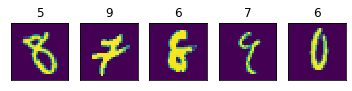

In [23]:
plot_example(X_test[error_mask], y_pred[error_mask])

## Grid search

```python

from sklearn.model_selection import GridSearchCV


params = {
    'module__dropout': [.25, .5],
    'module__num_hidden': [50, 100],
}
gs = GridSearchCV(net, params, refit=False, cv=3, scoring='accuracy', verbose=0)

gs.fit(X_train, y_train)
print(gs.best_score_, gs.best_params_)
```

# Convolutional Network
PyTorch expects a 4 dimensional tensor as input for its 2D convolution layer. The dimensions represent:
* Batch size
* Number of channel
* Height
* Width

As initial batch size the number of examples needs to be provided. MNIST data has only one channel. As stated above, each MNIST vector represents a 28x28 pixel image. Hence, the resulting shape for PyTorch tensor needs to be (x, 1, 28, 28). 

In [27]:
XCnn = X.reshape(-1, 1, 28, 28)

In [28]:
XCnn.shape

(70000, 1, 28, 28)

In [29]:
XCnn_train, XCnn_test, y_train, y_test = train_test_split(XCnn, y, test_size=.25, random_state=42)

In [30]:
XCnn_train.shape, y_train.shape

((52500, 1, 28, 28), (52500,))

In [31]:
class Cnn(nn.Module):
    def __init__(self, dropout=0.5):
        super(Cnn, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_drop = nn.Dropout2d(p=dropout)
        self.fc1 = nn.Linear(1600, 100)  # 1600 = number channels * width * height
        self.fc2 = nn.Linear(100, 10)
        self.fc1_drop = nn.Dropout(p=dropout)

    def forward(self, x):
        x = torch.relu(F.max_pool2d(self.conv1(x), 2))
        x = torch.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        
        # flatten over channel, height and width = 1600
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))
        
        x = torch.relu(self.fc1_drop(self.fc1(x)))
        x = torch.softmax(self.fc2(x), dim=-1)
        return x

In [32]:
torch.manual_seed(0)

cnn = NeuralNetClassifier(
    Cnn,
    max_epochs=10,
    lr=.002,
    optimizer=torch.optim.Adam,
    device=device,
)

In [33]:
cnn.fit(XCnn_train, y_train)

  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        3.9018       0.9656        0.1243  57.5661
      2        0.2552       0.9750        0.0823  61.9020
      3        0.1948       0.9794        0.0628  62.9813
      4        0.1688       0.9789        0.0672  60.8297
      5        0.1544       0.9830        0.0550  60.7544
      6        0.1424       0.9823        0.0572  62.7971
      7        0.1309       0.9825        0.0604  60.3971
      8        0.1302       0.9842        0.0538  59.6087
      9        0.1290       0.9844        0.0530  59.0908
     10        0.1227       0.9852        0.0512  60.5755


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Cnn(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (conv2_drop): Dropout2d(p=0.5, inplace=False)
    (fc1): Linear(in_features=1600, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=10, bias=True)
    (fc1_drop): Dropout(p=0.5, inplace=False)
  ),
)

In [34]:
y_pred_cnn = cnn.predict(XCnn_test)

In [35]:
accuracy_score(y_test, y_pred_cnn)

0.9830285714285715

An accuracy of >98% should suffice for this example!

Let's see how we fare on the examples that went wrong before:

In [36]:
accuracy_score(y_test[error_mask], y_pred_cnn[error_mask])

0.6805555555555556

Over 70% of the previously misclassified images are now correctly identified.

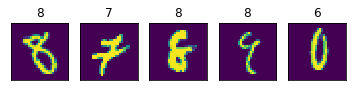

In [37]:
plot_example(X_test[error_mask], y_pred_cnn[error_mask])